# 1. Prepare

In [23]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import sys
import os
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns

#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize
from imports.models.data_generator import DataGenerator
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

SHAPE = (512,768)

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Check if GPU available:

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Read Dataframes:

In [5]:
df = pd.read_pickle(DATA_BASE_PATH+"/df")
df.head(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
0,../data/00_train_all/images/,../data/00_train_all/masks/,../data/00_train_all/masks_autogen/,img_1000.png,None,698 29 818 9 2234 31 2353 11 3770 31 3887 15 5...,334006 81 338587 135 343177 171 347770 201 352...,"[[756.8607304952216, 225.09973947065592], [710...","[[[691.7071068635969, 651.3522006904487], [726..."


### Load Splited Data

In [6]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


In [7]:
folder_files_train = os.listdir(DATA_BASE_PATH+'/01_train/images')
df_files_train = list(train_df['name'].values)
folder_files_train.sort()
df_files_train.sort()

folder_files_val = os.listdir(DATA_BASE_PATH+'/03_val/images')
df_files_val = list(val_df['name'].values)
folder_files_val.sort()
df_files_val.sort()

folder_files_test = os.listdir(DATA_BASE_PATH+'/04_test/images')
df_files_test = list(test_df['name'].values)
folder_files_test.sort()
df_files_test.sort()

assert folder_files_train == df_files_train, 'Train Files in Folder and Dataframe dont match'
assert folder_files_val == df_files_val, 'Validation Files in Folder and Dataframe dont match'
assert folder_files_test == df_files_test, 'Test Files in Folder and Dataframe dont match'

In [8]:
imgs = os.listdir(DATA_BASE_PATH+"/02_augmented/images")
files = {"image_path":DATA_BASE_PATH+"/02_augmented/images/",
             "mask_path":DATA_BASE_PATH+"/02_augmented/masks/",
             "mask_cirlce_path":DATA_BASE_PATH+"/02_augmented/masks_autogen/",
             "name":imgs}
aug_df = pd.DataFrame.from_dict(files)
aug_df.sample(3)
print(len(aug_df))

3540


In [9]:
train_df.sample(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
340,../data/00_train_all/images/,../data/00_train_all/masks/,../data/00_train_all/masks_autogen/,img_1004.png,None,447907 3 449444 3 450979 6 452515 4 454051 3 4...,1232617 81 1237198 135 1241788 171 1246381 201...,"[[703.1168333622936, 525.0542913693902], [773....","[[[720.9935958297133, 590.303801150748], [755...."


# 3 Training:

Weighted Loss Map Test:

In [10]:
# siehe notebook

### 3.1 Load UNet Model:

In [25]:
model = get_unet(input_shape=(*SHAPE,3),num_classes=2)

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 768, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 512, 768, 8)  32          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 512, 768, 8)  0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
conv2d_40 

### 3.2 Define Train- Generator:

In [13]:
params = {'target_size': SHAPE,
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True}

# Generators
sample_gen = DataGenerator(df=aug_df,augment_data=False,save_images=False,**params)
i_sample = iter(sample_gen)

Found 3540 Files


(4, 512, 768, 2)


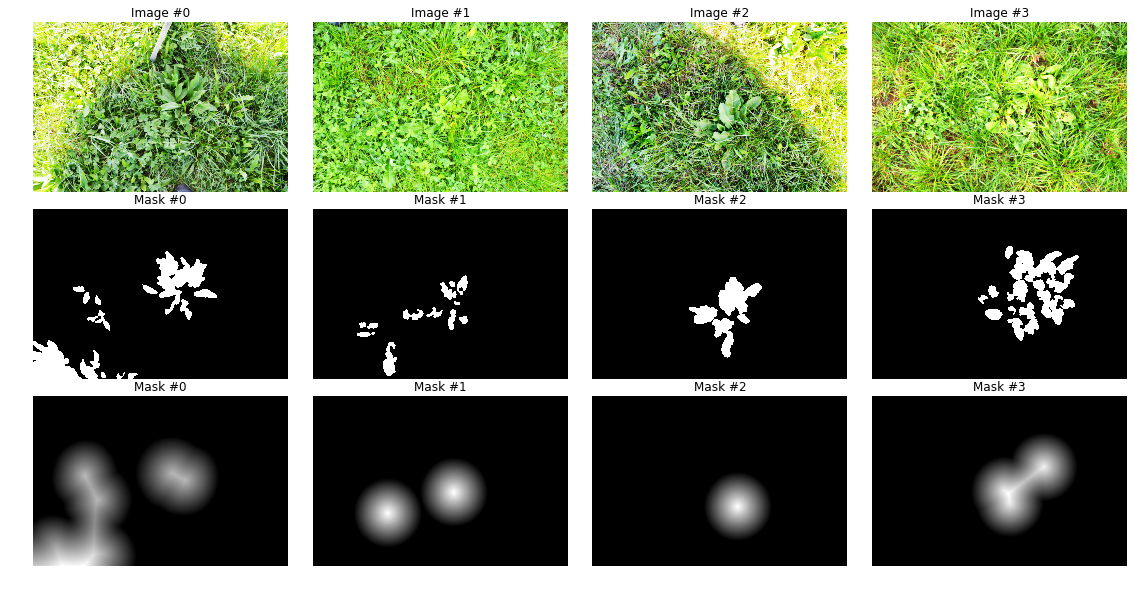

In [14]:
imgs,msks = next(i_sample)
print(msks.shape)
plt.figure(figsize=(20,10))
x,y =4,1
for i in range(y):
    for j in range(x):
        plt.subplot(y*3,x,i*2*x+j+1)
        pos = i+j
        plt.imshow(imgs[pos,:,:,:].reshape(512,768,3))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+1)*x+j+1)
        plt.imshow(msks[pos,:,:,0].reshape(SHAPE),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+2)*x+j+1)
        plt.imshow(msks[pos,:,:,1].reshape(SHAPE),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()

### 3.3 Initialize Generators:

### 3.5 Train:

In [27]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

BS = 4
import math
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate


checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_dice_coeff', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coeff', 
                                   factor=0.1, 
                                   patience=6, 
                                   verbose=1, 
                                   mode='max', 
                                   epsilon=0.0001, 
                                   cooldown=6, 
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_dice_coeff", 
                      mode="max", 
                      patience=15,
                      restore_best_weights=True)

tensorboard = TensorBoard(log_dir='../docs/tensorboard', 
                            histogram_freq=0, 
                            batch_size=BS, 
                            write_graph=True, 
                            write_grads=False, 
                            write_images=False, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None, 
                            embeddings_data=None, 
                            update_freq='epoch')

lr = LearningRateScheduler(step_decay)

callbacks_list = [early, reduceLROnPlat]

In [51]:
params = {'target_size': SHAPE,
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(df=aug_df,augment_data=False,save_images=False,**params)
validation_generator = DataGenerator(df=val_df,**params)

Found 3540 Files
Found 102 Files


In [46]:
# Calculate Steps per epoch
images_from_one = 10
steps_per_epoch = len(train_df)*images_from_one//BS
steps_per_epoch

885

In [ ]:
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(aug_df) // BS,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BS,
    epochs=50,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/50
328/885 [==========>...................] - ETA: 3:21 - loss: 2.0232 - seg1_loss: 1.3382 - seg2_loss: -0.6531 - seg1_dice_coeff: 0.1813 - seg2_iou: 0.6531

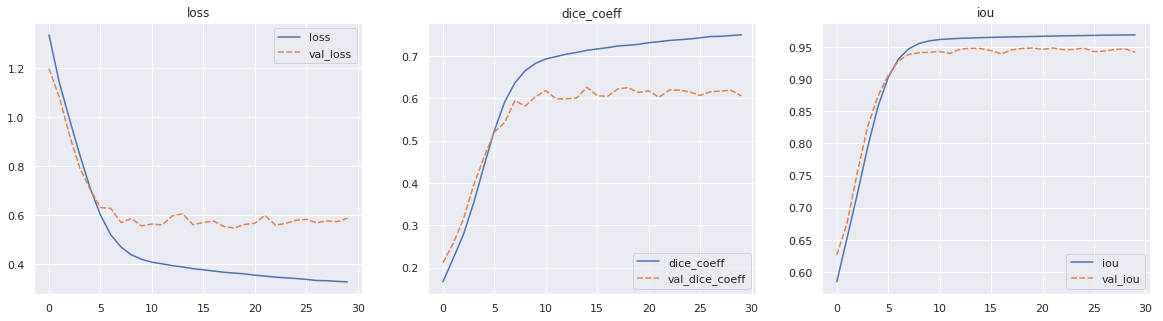

In [22]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "loss":H.history['loss'],
        "val_loss":H.history['val_loss']}
loss_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=loss_data).set_title("loss")

plt.subplot(1,3,2)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "dice_coeff":H.history['dice_coeff'],
        "val_dice_coeff":H.history['val_dice_coeff']}
dice_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=dice_data).set_title("dice_coeff")

plt.subplot(1,3,3)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "iou":H.history['iou'],
        "val_iou":H.history['val_iou']}
iou_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=iou_data).set_title("iou")

In [20]:
model.save('unet_dice_0.6058_iou_0.9414.h5')

In [21]:
loss_data.to_pickle("loss_data_df_unet_dice_0.6058_iou_0.9414")
dice_data.to_pickle("dice_data_df_unet_dice_0.6058_iou_0.9414")
iou_data.to_pickle("iou_data_df_unet_dice_0.6058_iou_0.9414")

In [118]:
val_df.sample(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
13,../data/00_train_all/images/,../data/00_train_all/masks/,../data/00_train_all/masks_autogen/,img_1289.png,None,521988 5 523520 13 525055 15 526589 17 528124 ...,1588519 81 1593100 135 1597690 171 1602283 201...,"[[682.7104973066897, 592.434404602992], [1036....","[[[600.6163906168548, 545.6905132336019], [505..."


In [129]:
from imports.utils.visualization import Evaluate

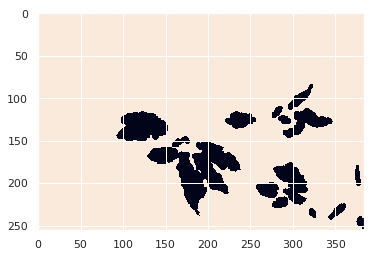

In [130]:
vis_params = {'df':val_df,
              'input_shape':(256,384,1),
              'model':model}

ev = Evaluate(**vis_params)
imshow(ev.get_false_negative_mask(1289))

### 3.7 Visualize Error Mask

In [84]:
vis_params = {'data_set':'val',
              'model':model}

predictions = Visualize(**vis_params)

Aufsummiern aller falsch detektieren Masken (False Positive + False Negative):

In [12]:
def predict_all_error(df):
    error_sum = np.zeros(SHAPE)
    for i, row in df.iterrows():
        err = predictions.get_error_mask(index=row['Name'])
        error_sum += err
    return error_sum

In [13]:
summed_mask_error = predict_all_error(df.loc[df['Dataset'] == 'val'])

Visualisierung aller überlagerten False Positiv + False Negativ Masken:

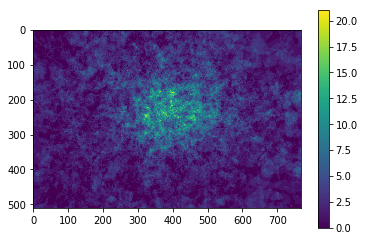

In [96]:
imshow(summed_mask_error)
plt.colorbar()

In [84]:
summed_mask_train = np.zeros(shape)
for i,row in df.iterrows():
    if row['Dataset'] == 'train':
        summed_mask_train += rle_decode(row['Mask'],(1024,1536))
summed_mask_train = resize(summed_mask_train,(512,768))

Vergleich der summierten Trainingsmasken (Bild rechts) mit den summierten Falschen vorhersagen (Bild mitte). Das Bild rechts zeigt die subtraktion der normalisierten Trainingsmasken mit den normalisierten False Positiv + False Negativ:

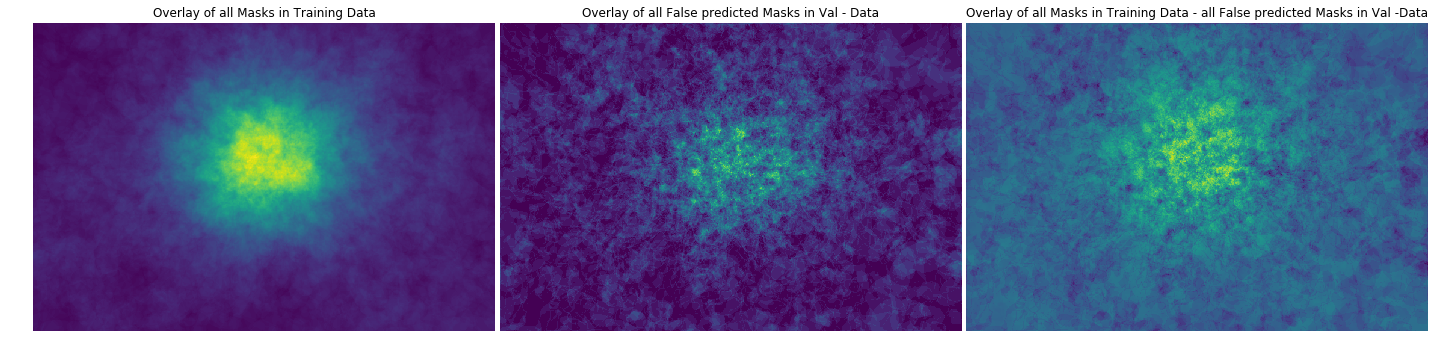

In [94]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(25,18))
axs[0].imshow(summed_mask_train)
axs[1].imshow(summed_mask_error)
#axs[1,0].imshow(summed_mask_train-summed_mask_error)
axs[2].imshow(summed_mask_train/summed_mask_train.max()-summed_mask_error/summed_mask_error.max())
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all False predicted Masks in Val - Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Training Data - all False predicted Masks in Val -Data')
axs[2].axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0)

Die meisten falsch vohergesagten Masken befinden sich zwar im Zentrum der Bilder (wie die meisten Masken in den Trainingsbildern), jedoch sind diese besser Verteilt als die Ground Truth Masken. (Die Farbskalierung der Bilder ist bei beiden gleich) 
Daraus schliesse ich, das sich die Anhäufung der GroundTruth- Masken in den Trainingsdaten im Zentrum, negativ auf die vorhersagen von Blacken im Randbereich asuwirkt. d.h. es werden im Randbereich der Bilder überdurchschnittlich viele Blacken falsch vorhergesagt.

<img src="../docs/notebook_images/False_negativ_positv.png">

In [24]:
df.loc[df['Dataset'] == "val"].sample(3)

,Path,Dataset,Name,Mask,Mask_Circle,Roots,Splines,Shape
478,../data/03_val/,val,1478,698 29 818 9 2234 31 2353 11 3770 31 3887 15 5...,536761 75 541348 117 545941 147 550537 171 555...,"[[756.860730495, 225.099739471], [710.69078575...","[[[691.707106864, 651.35220069], [726.09500191...","(1024, 1536, 3)"
417,../data/03_val/,val,1417,438508 3 440040 11 441574 15 443109 17 444644 ...,1887196 75 1891783 117 1896376 147 1900972 171...,"[[853.094844831, 518.794340161], [920.60268983...","[[[754.574568202, 359.710519678], [737.6823047...","(1024, 1536, 3)"
475,../data/03_val/,val,1475,107007 1 108539 9 110036 1 110073 13 111569 8 ...,76405 75 80992 117 85585 147 90181 171 94780 1...,"[[797.386664813, 489.076010127], [904.84234231...","[[[608.502080278, 474.114327273], [696.4633244...","(1024, 1536, 3)"


float64


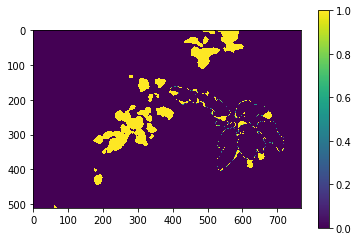

In [106]:
fe = predictions.get_full_error_mask(index='1357')
print(fe.dtype)
imshow(fe)
plt.colorbar()

float64


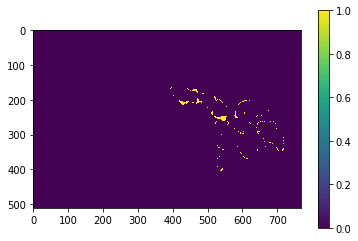

In [92]:
fp = predictions.get_false_positive_mask(index='1357')
print(fp.dtype)
imshow(fp)
plt.colorbar()

float64


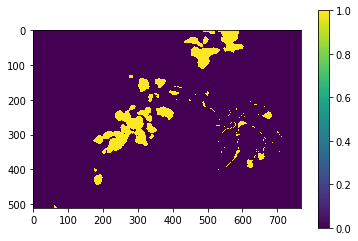

In [91]:
fn = predictions.get_false_negative_mask(index='1357')
print(fn.dtype)
imshow(fn)
plt.colorbar()

### Old: